# **Finding the rate change in CAP features from day to day and from 1 to 7**
## This will help us to figure how often we should call the model to check the stage change. 
## Also it has effect on architectural design.

In [1]:
%run bi_feature_eng_utilities.ipynb 
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables

    100% |████████████████████████████████| 122kB 25.0MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 6.1MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 5.7MB 8.3MB/s eta 0:00:011
    100% |████████████████████████████████| 235kB 55.2MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/36/fa/08e9e6e0e3cbd1d362c3bbee8d01d0aedb2155c4ac112b19ef3cae8eed8d/docutils-0.14-py3-none-any.whl
    100% |████████████████████████████████| 153kB 23.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for move-dl-common-api ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/77/47/62e0d2c17e9e2a7818ed7bab55e570ecd03f4ec8b9f33121f1

In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing

# Random Sample input data if too large this number should be presented as integer ]0,100]
sample_rate_percentage = 100

s3 = s3fs.S3FileSystem()

In [3]:
user_interactions_db_handler= FeatureEngineeringUtilities(db_name= 'buyer_intent_user_interactions', 
                                                          db_path_on_s3 = 's3://datascience-workspace-dev/buyer-intent/user_interactions', 
                                                          logger_name = 'buyer_intent')

2019-08-14 17:37:05.032 INFO athena_util.py.111 - Read config from default schema
2019-08-14 17:37:05.033 INFO athena_util.py.114 - Schema fetched from default config file:


In [4]:
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t180'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))

user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t180',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t180'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t030',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t007',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t001',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

2019-08-14 17:37:05.073 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-14 17:37:05.199 INFO athena_util.py.462 - 2019-08-14 17:37:05.199648
2019-08-14 17:37:06.748 INFO athena_util.py.464 - 2019-08-14 17:37:06.748224
2019-08-14 17:37:06.810 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-14 17:37:06.866 INFO athena_util.py.462 - 2019-08-14 17:37:06.866749
2019-08-14 17:37:08.411 INFO athena_util.py.464 - 2019-08-14 17:37:08.411639
2019-08-14 17:37:08.473 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-14 17:37:08.547 INFO athena_util.py.462 - 2019-08-14 17:37:08.547098
2019-08-14 17:37:10.094 INFO athena_util.py.464 - 2019-08-14 17:37:10.094498
2019-08-14 17:37:10.153 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-14 17:37:10.242 INFO athena_util.py.462 - 2019-08-14 17:37:10.242065
2019-08-14 17

0

In [5]:
s3_data_path_030 = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t030'.format(str(int((100/sample_rate_percentage)*100))))

s3_data_path_007 = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t007'.format(str(int((100/sample_rate_percentage)*100))))

s3_data_path_001 = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t001'.format(str(int((100/sample_rate_percentage)*100))))

In [6]:
df_001 = pq.ParquetDataset(s3_data_path_001, filesystem=s3).read_pandas().to_pandas()
df_007 = pq.ParquetDataset(s3_data_path_007, filesystem=s3).read_pandas().to_pandas()
df_030 = pq.ParquetDataset(s3_data_path_030, filesystem=s3).read_pandas().to_pandas()

In [7]:
df_001 = df_001.drop(columns = ['snapshot_date_mst_yyyymmdd','most_recent_ldp_visit_date','ldp_dominant_zip','ldp_dominant_segment','total_listings_viewed','median_distinct_listings_viewed','average_distinct_listings_viewed','median_listings_viewed','average_total_listings_viewed'] )
df_007 = df_007.drop(columns = ['snapshot_date_mst_yyyymmdd','most_recent_ldp_visit_date','ldp_dominant_zip','ldp_dominant_segment','total_listings_viewed','median_distinct_listings_viewed','average_distinct_listings_viewed','median_listings_viewed','average_total_listings_viewed'] )
df_030 = df_030.drop(columns = ['snapshot_date_mst_yyyymmdd','most_recent_ldp_visit_date','ldp_dominant_zip','ldp_dominant_segment','total_listings_viewed','median_distinct_listings_viewed','average_distinct_listings_viewed','median_listings_viewed','average_total_listings_viewed'] )

In [8]:
common_member_ids_01_07 = set(df_001['member_id']).intersection(set(df_007['member_id']))
common_member_ids_01_30 = set(df_001['member_id']).intersection(set(df_030['member_id']))

In [9]:
df_007_common_01 = df_007[df_007['member_id'].isin(common_member_ids_01_07)]
df_001_common_07 = df_001[df_001['member_id'].isin(common_member_ids_01_07)]

In [10]:
df_007_common_group_by_member_id_001 = df_007_common_01.groupby('member_id').agg('mean')
df_007_common_group_by_member_id_001.sort_values('member_id')
df_007_common_group_by_member_id_001.head(5)

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed
member_id,,,,,,,,,
10000112,8.000000,1.000000,1.000000,16.125000,129.000000,17.000000,3.000000,39.000000,8.000000
10000142,82.166667,1.833333,2.221742,31.810886,1049.791667,16.458333,1.416667,214.375000,35.625000
10000165,10.888889,1.111111,1.159722,55.027778,519.777778,49.666667,8.777778,168.888889,7.666667
10000190,71.041667,1.000000,1.119706,27.424702,1977.041667,20.208333,5.041667,128.625000,57.291667
10000201,14.444444,1.000000,1.078836,22.752718,301.444444,19.888889,1.111111,55.888889,11.555556


In [11]:
df_001_common_group_by_member_id_007 = df_001_common_07.groupby('member_id').agg('mean')
df_001_common_group_by_member_id_007.sort_values('member_id')
df_001_common_group_by_member_id_007.head(5)

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed
member_id,,,,,,,,,
10000112,8.000000,1.000000,1.000000,16.125000,129.000000,17.000000,3.000000,39.000000,8.000000
10000142,38.454545,1.909091,2.390726,43.139117,521.636364,32.181818,3.272727,174.363636,16.545455
10000165,16.666667,1.333333,1.523810,74.071429,822.333333,56.333333,8.333333,280.666667,9.000000
10000190,27.066667,1.000000,1.072448,23.610705,744.866667,17.000000,5.533333,81.933333,23.600000
10000201,9.666667,1.000000,1.108974,23.317949,194.333333,20.333333,1.333333,53.666667,8.666667


In [12]:
res = abs(df_007_common_group_by_member_id_001.subtract(df_001_common_group_by_member_id_007,fill_value=0))

total_ldp_page_views                50.979843
median_ldp_page_views                0.367233
average_ldp_page_views               0.283002
average_ldp_dwell_time_seconds      31.212085
total_ldp_dwell_time_seconds      1376.719771
median_ldp_dwell_time_seconds       44.749434
minimum_ldp_dwell_time_seconds      34.841915
maximum_ldp_dwell_time_seconds     228.030269
total_distinct_listings_viewed      18.584858
dtype: float64


Text(0, 0.5, 'Frequency')

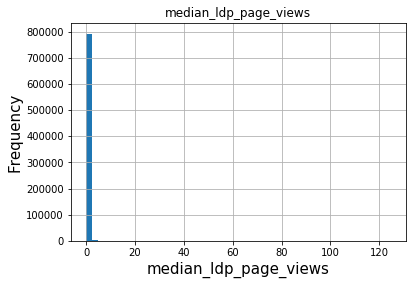

In [13]:
print(res.std())
res.hist(column='median_ldp_page_views', bins=50)
plt.xlabel("median_ldp_page_views",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

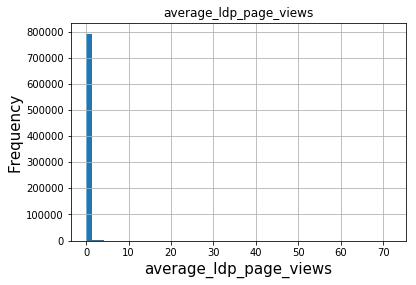

In [14]:
res.hist(column='average_ldp_page_views', bins=50)
plt.xlabel("average_ldp_page_views",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

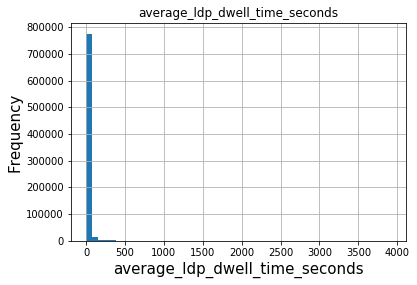

In [15]:
res.hist(column='average_ldp_dwell_time_seconds', bins=50)
plt.xlabel("average_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

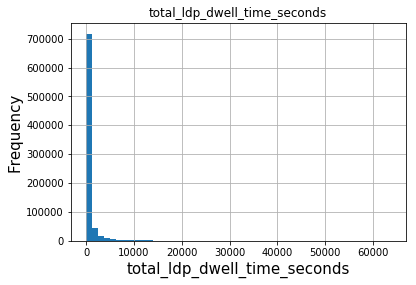

In [16]:
res.hist(column='total_ldp_dwell_time_seconds', bins=50)
plt.xlabel("total_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

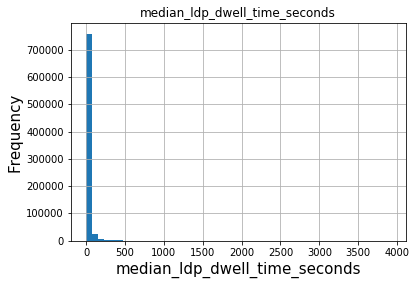

In [17]:
res.hist(column='median_ldp_dwell_time_seconds', bins=50)
plt.xlabel("median_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

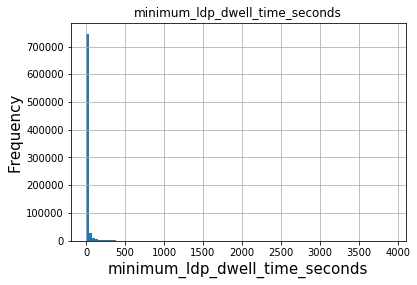

In [18]:
res.hist(column='minimum_ldp_dwell_time_seconds', bins=100)
plt.xlabel("minimum_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

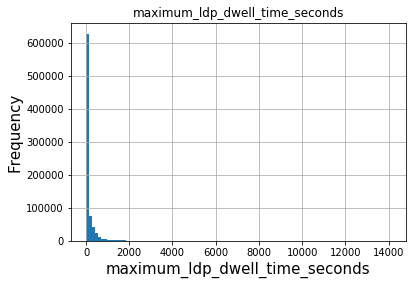

In [19]:
res.hist(column='maximum_ldp_dwell_time_seconds', bins=100)
plt.xlabel("maximum_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

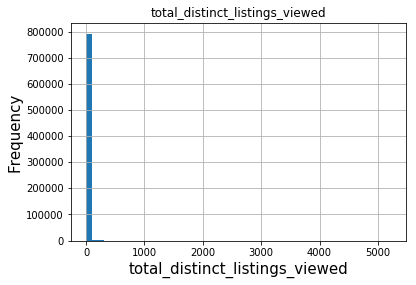

In [20]:
res.hist(column='total_distinct_listings_viewed', bins=50)
plt.xlabel("total_distinct_listings_viewed",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

In [21]:
df_001_common_30 = df_001[df_001['member_id'].isin(common_member_ids_01_30)]
df_030_common_01 = df_030[df_030['member_id'].isin(common_member_ids_01_30)]

df_030_common_group_by_member_id_001 = df_030_common_01.groupby('member_id').agg('mean')
df_030_common_group_by_member_id_001.sort_values('member_id')
df_030_common_group_by_member_id_001.head(5)

df_001_common_group_by_member_id_030 = df_001_common_30.groupby('member_id').agg('mean')
df_001_common_group_by_member_id_030.sort_values('member_id')
df_001_common_group_by_member_id_030.head(5)

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed
member_id,,,,,,,,,
10000112,8.000000,1.000000,1.000000,16.125000,129.000000,17.000000,3.000000,39.000000,8.000000
10000142,38.454545,1.909091,2.390726,43.139117,521.636364,32.181818,3.272727,174.363636,16.545455
10000165,16.666667,1.333333,1.523810,74.071429,822.333333,56.333333,8.333333,280.666667,9.000000
10000190,27.066667,1.000000,1.072448,23.610705,744.866667,17.000000,5.533333,81.933333,23.600000
10000201,9.666667,1.000000,1.108974,23.317949,194.333333,20.333333,1.333333,53.666667,8.666667


In [22]:
res = abs(df_030_common_group_by_member_id_001.subtract(df_001_common_group_by_member_id_030,fill_value=0))

total_ldp_page_views               153.852811
median_ldp_page_views                0.604331
average_ldp_page_views               0.504032
average_ldp_dwell_time_seconds      79.979332
total_ldp_dwell_time_seconds      5139.047237
median_ldp_dwell_time_seconds       83.295410
minimum_ldp_dwell_time_seconds      64.930759
maximum_ldp_dwell_time_seconds     636.078528
total_distinct_listings_viewed      50.566763
dtype: float64


Text(0, 0.5, 'Frequency')

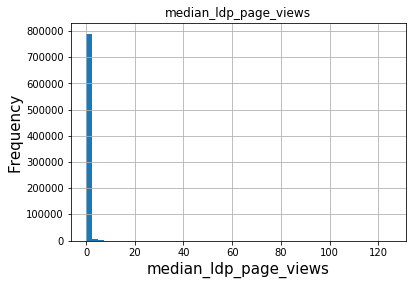

In [23]:
print(res.std())
res.hist(column='median_ldp_page_views', bins=50)
plt.xlabel("median_ldp_page_views",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

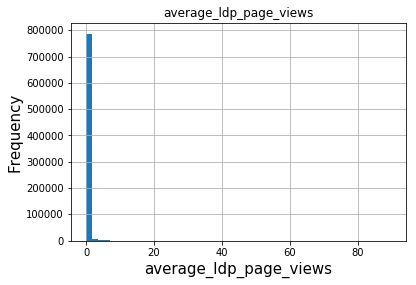

In [24]:
res.hist(column='average_ldp_page_views', bins=50)
plt.xlabel("average_ldp_page_views",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

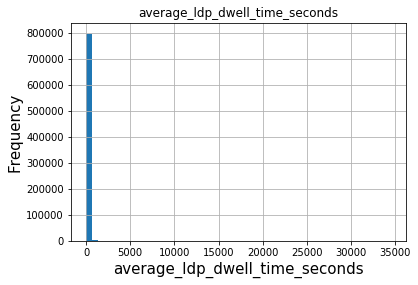

In [25]:
res.hist(column='average_ldp_dwell_time_seconds', bins=50)
plt.xlabel("average_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

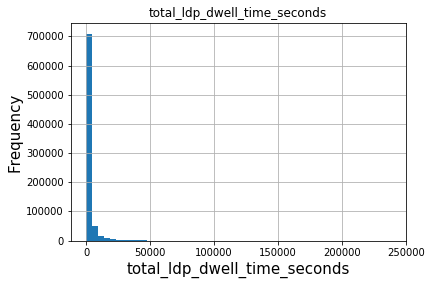

In [26]:
res.hist(column='total_ldp_dwell_time_seconds', bins=50)
plt.xlabel("total_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

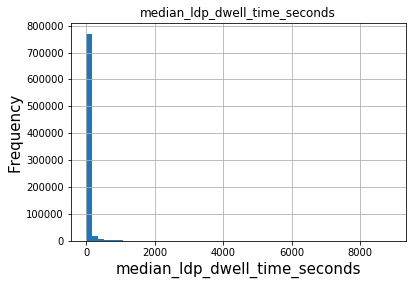

In [27]:
res.hist(column='median_ldp_dwell_time_seconds', bins=50)
plt.xlabel("median_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

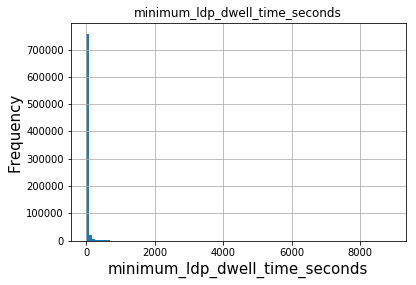

In [28]:
res.hist(column='minimum_ldp_dwell_time_seconds', bins=100)
plt.xlabel("minimum_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

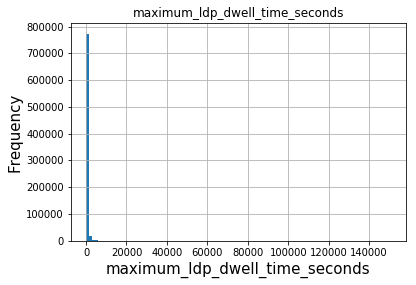

In [29]:
res.hist(column='maximum_ldp_dwell_time_seconds', bins=100)
plt.xlabel("maximum_ldp_dwell_time_seconds",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

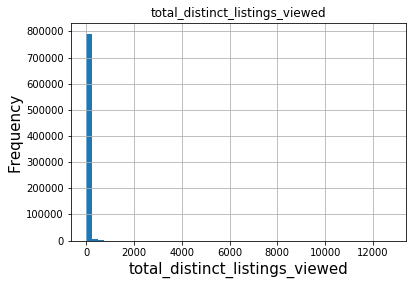

In [30]:
res.hist(column='total_distinct_listings_viewed', bins=50)
plt.xlabel("total_distinct_listings_viewed",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

## Based on comparing changes between today, yesterday, today and last 7 days and today and last 30 days, we don't have significant changes in behaviour from today and yesterday for almost all users in different segments (99.98% correleation). So recommended time frame to call model to predict stage will **be >> 1** day but less than **30** days. In has significant change for 30 days but I could not find that. 